In [1]:
%load_ext autoreload
%autoreload 2

## Apprentissage des aspects explicites

### Importation des bibliothèques

In [2]:
import os
os.chdir("..")

In [3]:
import seaborn as sns
from collections import Counter
from time import time
from Preprocessors.ReviewPreprocessor import ReviewPreprocessor
from Aspects.ExplicitAspectExtractor import ExplicitAspectExtractor
import pandas as pd
import spacy
nlp = spacy.load("en_core_web_sm")
import numpy as np

### Fonction de pretraitement des datasets

La fonction prend un dictionnaire de jeux de données. il a comme clé un nom pour identifier le dataset et comme valeur le chemin vers le dataset.

In [4]:
def clean_datasets(datasets):
    cleaned_datasets = []
    for dataset_name in datasets:
        print(f"cleaning dataset {dataset_name}")
        dataset = pd.read_csv(datasets[dataset_name])
        old = time()
        review_preprocessor = ReviewPreprocessor(dataset['review'], nlp)
        dataset['cleaned_data'] = review_preprocessor.remove_tags()
        dataset['cleaned_data'] = review_preprocessor.lowercase_transformation()
        dataset['cleaned_data'] = review_preprocessor.pararel_spelling_correction()
        dataset['cleaned_data'] = review_preprocessor.remove_objective_sentences()
        dataset = dataset[dataset['cleaned_data'] != ""]
        print(f"cleaning {dataset_name} took {time() - old}")
        cleaned_datasets.append((dataset_name, dataset))
    return cleaned_datasets

### Fonction d'extraction des aspects et de calcule de proportion de chaque aspect.

La fonction prend comme paramètre un dictionnaire des datasets prétraités. Il applique l'algorithme de l'extraction des aspects explicites avec leur nombre d'occurrence. Pour calculer la proportion de chaque aspect nous utilisons la relation suivante:

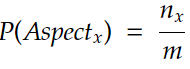

avec 

- **nx :** le nombre d'occurrence de l'aspect x.
- **m:** la somme d'occurrence de tous les aspects fréquents.

In [5]:
def extract_aspects_with_proportion(cleaned_datasets, aspects_threshold = 250):
    result = []
    for cleaned_dataset in cleaned_datasets:
        print(f"extracting aspects from {cleaned_dataset[0]}")
        old = time()
        explicit_aspect_extractor = ExplicitAspectExtractor(cleaned_dataset[1]['cleaned_data'], nlp)
        explicit_aspect_extractor.extract_aspects()
        frequent_aspects = explicit_aspect_extractor.get_frequent_aspects(aspects_threshold)
        sum_occurences = sum(Counter(dict(frequent_aspects)).values())
        aspects_proportion = []
        for i in frequent_aspects:
            aspects_proportion.append((i[0], i[1]/sum_occurences))
        result.append((cleaned_dataset[0], frequent_aspects, aspects_proportion))
        print(f"duration took for extracting explicit aspects and convert to proportion {time() - old}")
    return result

### Application de prétraitement

Les jeux de données utilisés dans cette notebook sont collectés à l'aide de module de scraping créé pour le projet.

- les datasets **tripadvisor**, **booking** et **agoda** contient des commentaires de 10 hôtels à Paris, en total chaque dataset contient respectivement 2141, 1022, 230 commentaires.
- les datasets **agoda_london** et **tripadivsor_london** contient des commentaires de 5 hôtels à Londres, en total chaque dataset contient respectivement 245 et 658.

In [6]:
old = time()
datasets = {'tripadvisor': 'data/3 datasets/reviews_TripAdvisor_2022_5_20_11_27_56_ 10pages_10hotels.csv',
                    'booking': 'data/3 datasets/reviews_Booking_2022_5_20_11_9_54_10links_10_pages.csv',
                    'agoda': 'data/3 datasets/reviews_Agoda_2022_5_20_10_58_5_10pages_10_links.csv',
                    'agoda_london':'data/3 datasets/reviews_Agoda_2022_5_21_11_32_11_London_5pages_5links.csv',
                    'tripadvisor_london': 'data/3 datasets/reviews_TripAdvisor_2022_5_21_11_51_26_london_5pages_5links.csv'}
cleaned_datasets = clean_datasets(datasets)
print(f"duration : {time() - old}")

cleaning dataset tripadvisor


2141it [00:51, 41.88it/s]


cleaning tripadvisor took 225.59179949760437
cleaning dataset booking


1022it [00:12, 81.72it/s]


cleaning booking took 34.990506172180176
cleaning dataset agoda


230it [00:02, 77.67it/s]


cleaning agoda took 17.068331003189087
cleaning dataset agoda_london


245it [00:04, 49.23it/s]


cleaning agoda_london took 24.519328832626343
cleaning dataset tripadvisor_london


658it [00:17, 38.34it/s]

cleaning tripadvisor_london took 66.49089360237122
duration : 368.74653673171997


### Application d'extraction des aspects explicites.

In [7]:
all_aspects_prob_freq = extract_aspects_with_proportion(cleaned_datasets)

extracting aspects from tripadvisor
duration took for extracting explicit aspects and convert to proportion 31.917407512664795
extracting aspects from booking
duration took for extracting explicit aspects and convert to proportion 7.769307851791382
extracting aspects from agoda
duration took for extracting explicit aspects and convert to proportion 1.7504041194915771
extracting aspects from agoda_london
duration took for extracting explicit aspects and convert to proportion 2.2349345684051514
extracting aspects from tripadvisor_london
duration took for extracting explicit aspects and convert to proportion 10.4271719455719


**Affichage des valeurs de proportion pour les 30 aspects explicites les plus fréquents.**

In [8]:
only_aspects = []
for all_aspect_prob_freq in all_aspects_prob_freq:
    print(all_aspect_prob_freq[0])
    print("--------------------------------------------------")
    print(all_aspect_prob_freq[2][0:30])
    print("===================================")
    only_aspects.append(set(dict(all_aspect_prob_freq[1]).keys()))

tripadvisor
--------------------------------------------------
[('hotel', 0.09781887849089971), ('room', 0.08919755360695601), ('staff', 0.04686463783066834), ('breakfast', 0.03931176774003389), ('location', 0.03297472551764793), ('day', 0.01646894112445656), ('restaurant', 0.016321568049517354), ('stay', 0.01606366516837374), ('night', 0.014958367106329674), ('area', 0.014184658462898828), ('service', 0.014074128656694423), ('drink', 0.012747770982241545), ('bed', 0.012158278682484711), ('bar', 0.011716159457667085), ('time', 0.011163510426645052), ('bathroom', 0.010979294082971042), ('snack', 0.010647704664357821), ('eiffel', 0.01061086139562302), ('tower', 0.00943187679610935), ('place', 0.009395033527374549), ('lot', 0.0085476383464741), ('metro', 0.008437108540269692), ('coffee', 0.008363422002800089), ('minute', 0.007773929703043254), ('floor', 0.007294967209490826), ('reception', 0.007221280672021222), ('shower', 0.007073907597082013), ('station', 0.006779161447203596), ('street

In [9]:
len(set.intersection(*only_aspects))

221

- Parmi 250 aspects extraits depuis chaque dataset, il y a 221 aspects communs entre les cinq datasets.
- les aspects plus fréquents ont des valeurs de proportion proches entre eux. par exemple
    - l'aspects room {tripadvisor : 0.0891, booking: 0.0938, agoda: 0.0938, agoda_london: 0.0951, tripadvisor_london:0.0947}
    - l'aspects hotel {tripadvisor : 0.0978, booking: 0.0926, agoda: 0.0926, agoda_london: 0.0920, tripadvisor_london:0.0908}

### Construction d'un dataframe aspect/dataset

le dataframe a comme colonnes les aspects, et comme lignes le nom de dataset et comme valeurs la proportion calculé multiplié par 100.

ce dataframe est construit afin de calculer la variance de proportion pour aspects.

In [10]:
pds = []
for all_aspect_prob_freq in all_aspects_prob_freq:
    test_ = pd.DataFrame(all_aspect_prob_freq[2], columns=['aspect', 'proportion']).transpose()
    test_.columns = test_.loc['aspect',:]
    test_ = test_.drop('aspect')
    pds.append(test_)

In [11]:
rounded_proportion = pd.concat([pds[0], pds[1], pds[2], pds[3], pds[4]]).dropna(axis=1)*100
rounded_proportion.index = list(datasets.keys())

In [12]:
rounded_proportion

aspect,hotel,room,staff,breakfast,location,day,restaurant,stay,night,area,...,hallway,light,rate,parking,carpet,reason,entrance,cleanliness,cup,pressure
tripadvisor,9.781888,8.919755,4.686464,3.931177,3.297473,1.646894,1.632157,1.606367,1.495837,1.418466,...,0.08474,0.08474,0.08474,0.08474,0.08474,0.081055,0.081055,0.077371,0.077371,0.073687
booking,9.262132,9.38875,4.858979,3.925169,3.545314,1.560571,1.595391,1.506758,1.490931,1.319996,...,0.088633,0.098129,0.085467,0.158273,0.126618,0.098129,0.085467,0.091798,0.082302,0.085467
agoda,9.262441,9.388231,4.887403,3.881082,3.647911,1.546297,1.583113,1.497208,1.481868,1.310057,...,0.085905,0.098178,0.085905,0.153402,0.128858,0.101246,0.085905,0.09511,0.082837,0.082837
agoda_london,9.201784,9.51481,4.934589,3.779937,3.679532,1.509022,1.547412,1.509022,1.541505,1.290494,...,0.085639,0.100405,0.085639,0.156513,0.135841,0.100405,0.082686,0.097451,0.094498,0.085639
tripadvisor_london,9.082493,9.472299,5.074794,3.630074,3.595966,1.420358,1.5373,1.600643,1.598207,1.266871,...,0.080398,0.126687,0.099888,0.143741,0.136432,0.116942,0.082834,0.08527,0.08527,0.102324


### Calcul de Variance et écart type

In [13]:
vars_ = rounded_proportion.var()
stds_ = rounded_proportion.std()

In [14]:
vars_ = vars_.sort_values(ascending=False)
stds_ = stds_.sort_values(ascending=False)

#### Graphique des variances

In [15]:
sns.set(rc={'figure.figsize':(50,8)})

**variance des 30 premier aspects explicites**

<AxesSubplot:>

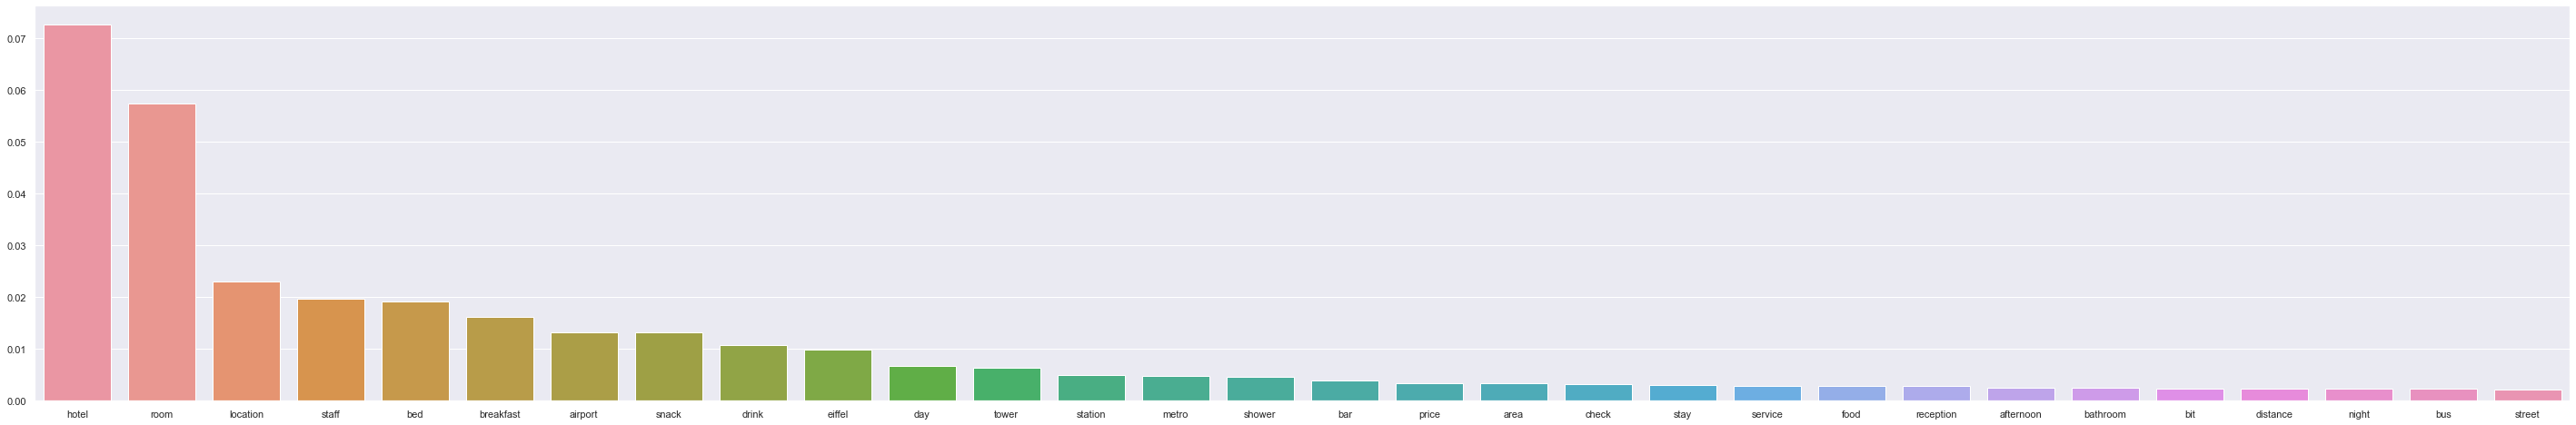

In [16]:
sns.barplot(x = list(vars_.index)[0:30], y= list(vars_)[0:30])

**variance des 30 dernier aspects explicites**

<AxesSubplot:>

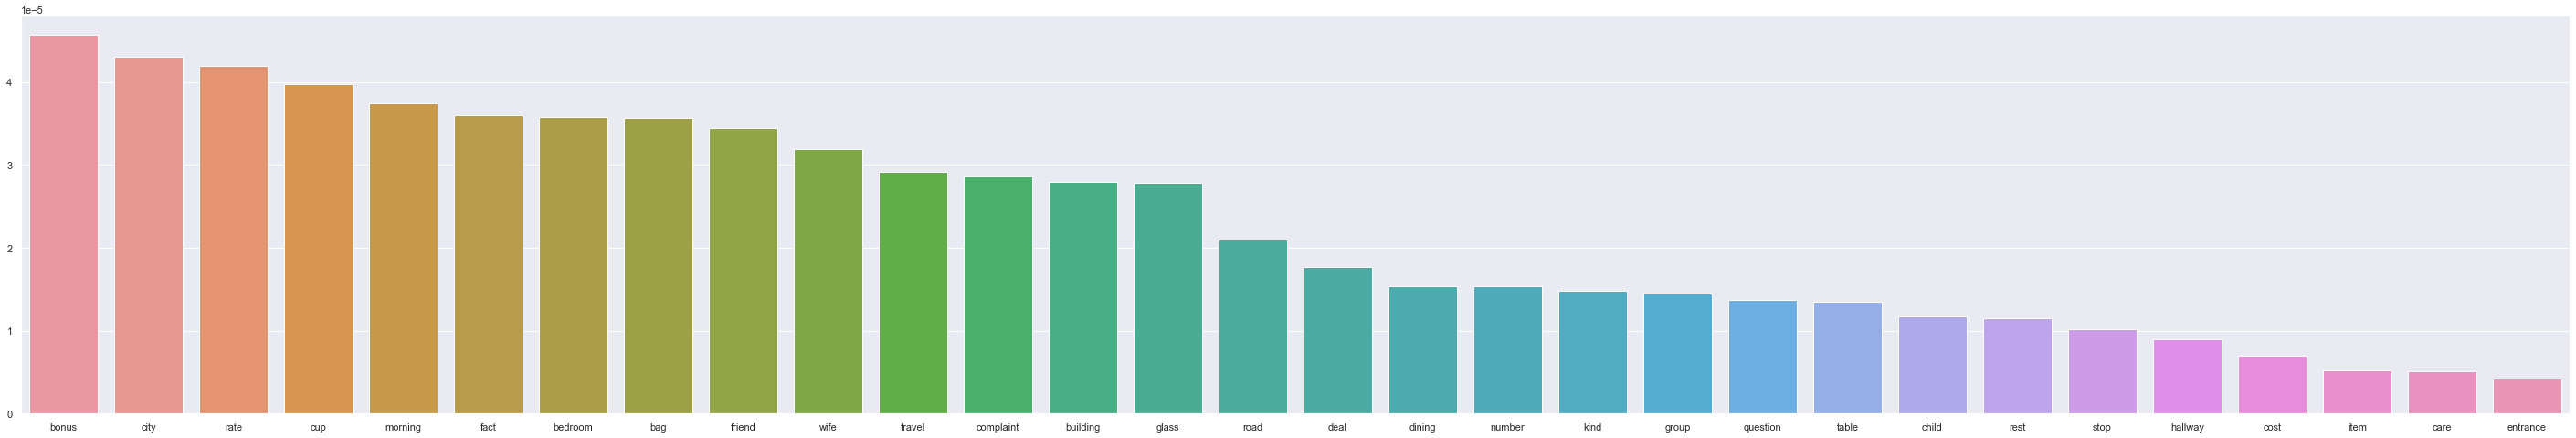

In [17]:
sns.barplot(x = list(vars_.index)[-30:], y= list(vars_)[-30:])

#### Graphique des écarts-types.

**écart type des 30 premier aspects explicites.**

<AxesSubplot:>

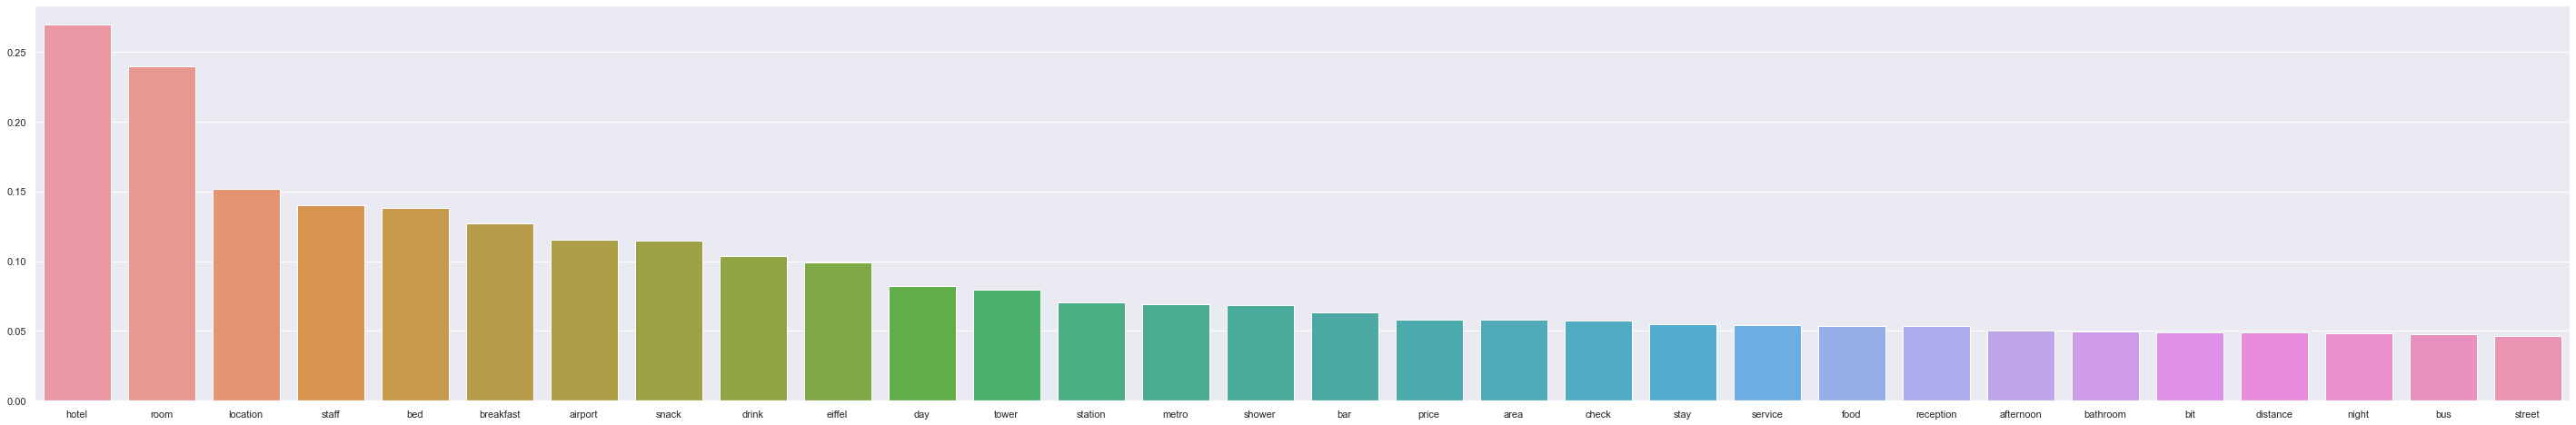

In [18]:
sns.barplot(x = list(stds_.index)[0:30], y= list(stds_)[0:30])

**écart type des 30 dernier aspects explicites.**

<AxesSubplot:>

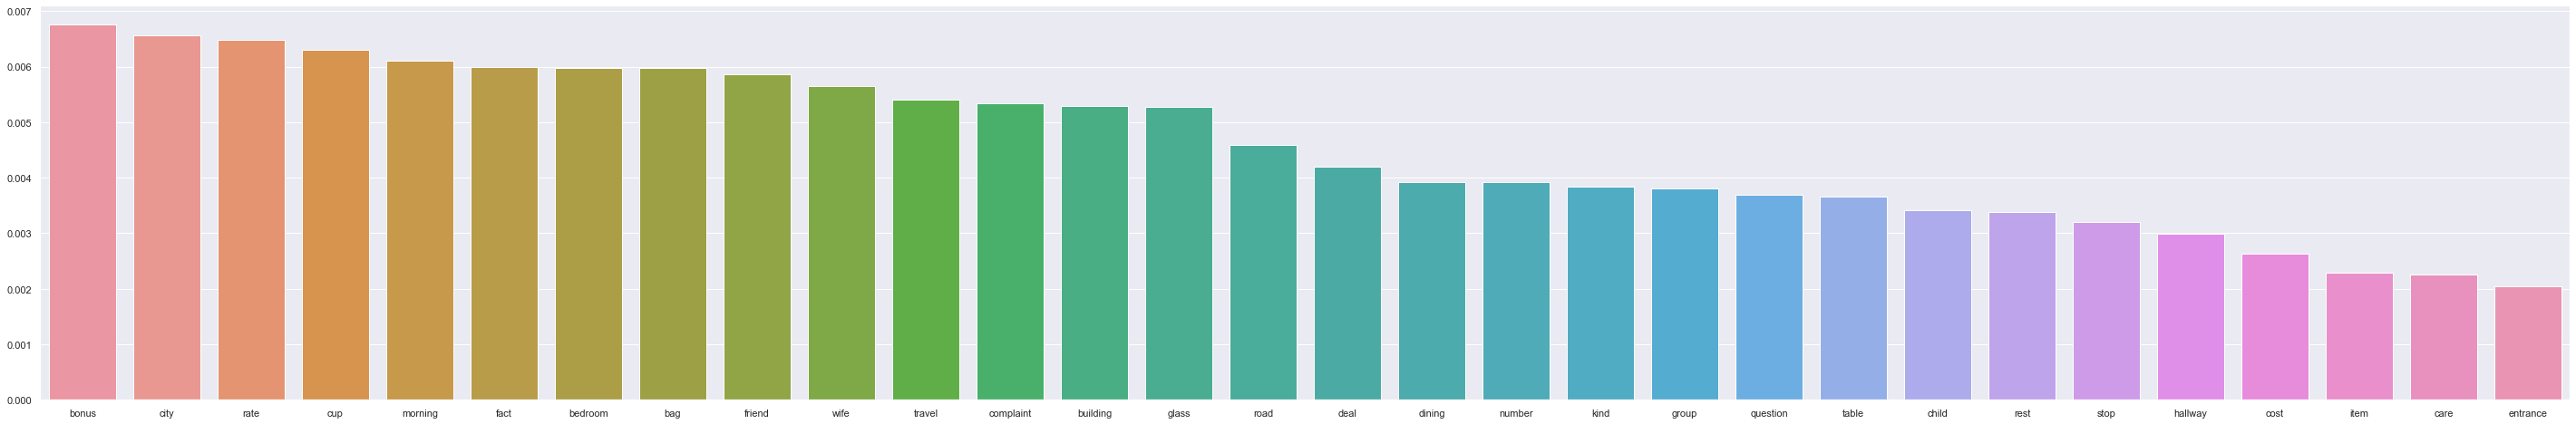

In [19]:
sns.barplot(x = list(stds_.index)[-30:], y= list(stds_)[-30:])

### Remarques

- Les aspects les plus fréquents dans les quatre jeux de données ont une petite variance , par exemple pour l’aspect hotel il a comme variance la valeur 0,07.
- Si on compare la variance de l’aspect ‘hotel’ (0,07) avec la variance de l’aspect ‘lobby’ (0,0005), nous remarquons que la variance de ‘hotel’ est plus grande que ‘lobby’. Cette grande différence est due aux valeurs de proportions de ‘lobby’ qui sont proches de zéro.

In [20]:
rounded_proportion['lobby']

tripadvisor           0.464225
booking               0.433668
agoda                 0.423391
agoda_london          0.410478
tripadvisor_london    0.406861
Name: lobby, dtype: object

In [21]:
rounded_proportion['hotel']

tripadvisor           9.781888
booking               9.262132
agoda                 9.262441
agoda_london          9.201784
tripadvisor_london    9.082493
Name: hotel, dtype: object

In [22]:
vars_['hotel'], vars_['lobby']

(0.07259244659153166, 0.0005297912699953506)

### Visualisation des proportion

In [23]:
df = rounded_proportion.reset_index().rename(columns={'index':'dataset'}).melt(id_vars="dataset", 
        var_name="aspect",
        value_name="proportion")

#### Proportion de première 15 aspects fréquents.

<AxesSubplot:xlabel='aspect', ylabel='proportion'>

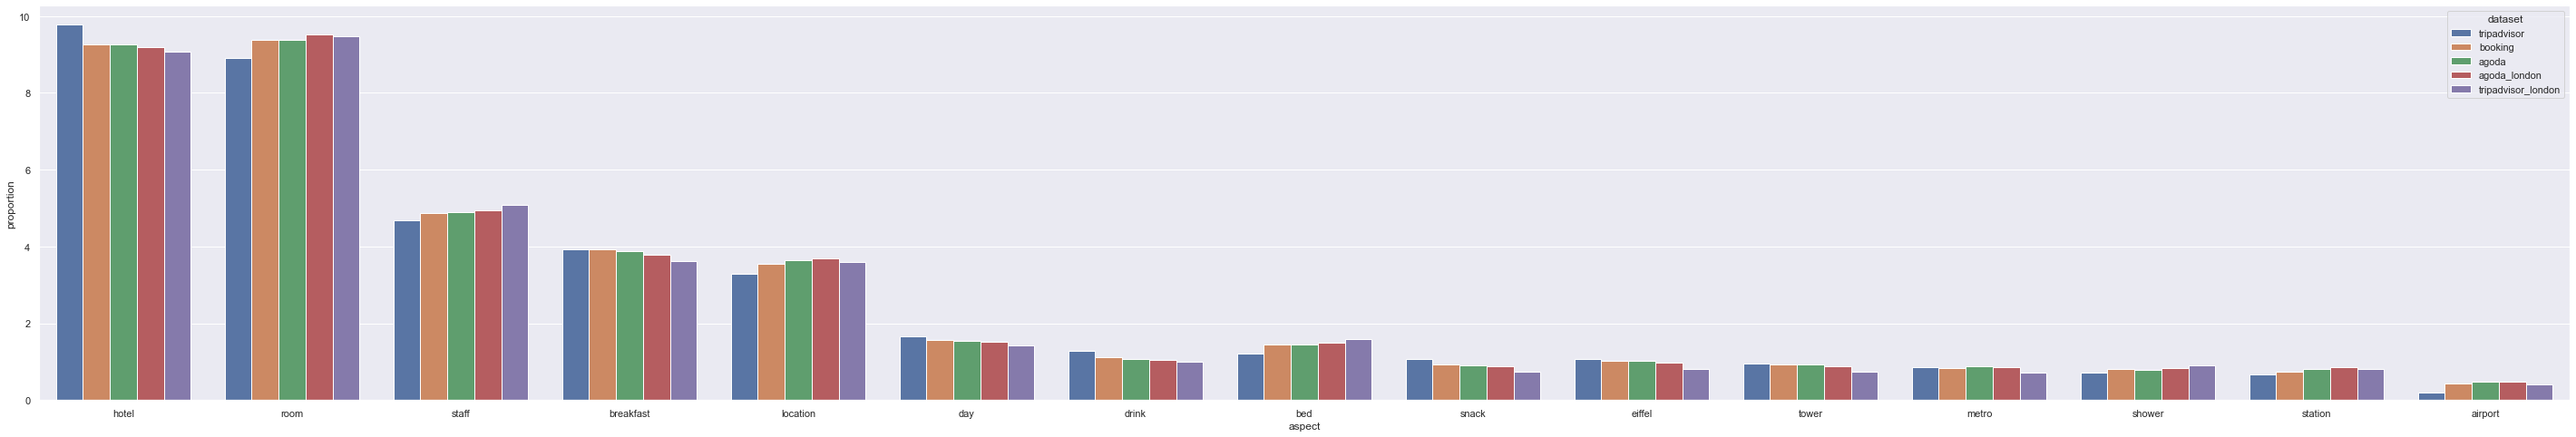

In [24]:
sns.barplot(data = df.query(f"aspect in {list(vars_[0:15].index)}"),
            x= 'aspect', y= 'proportion', hue='dataset')

#### Proportion des aspect avec un position entre 50 et 65

<AxesSubplot:xlabel='aspect', ylabel='proportion'>

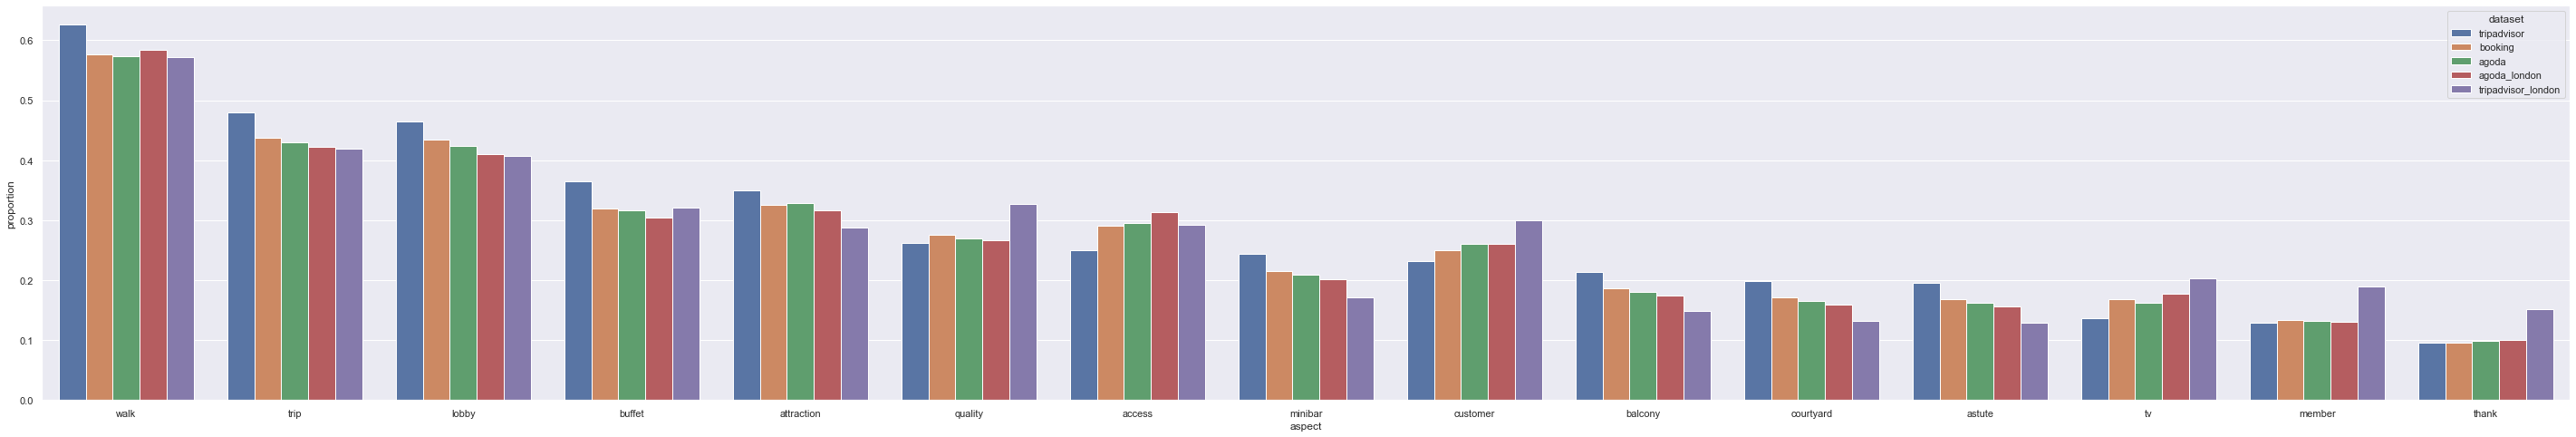

In [25]:
sns.barplot(data = df.query(f"aspect in {list(vars_[50:65].index)}"),
            x= 'aspect', y= 'proportion', hue='dataset')

#### Proprtion des aspect avec un position entre 100 et 115

<AxesSubplot:xlabel='aspect', ylabel='proportion'>

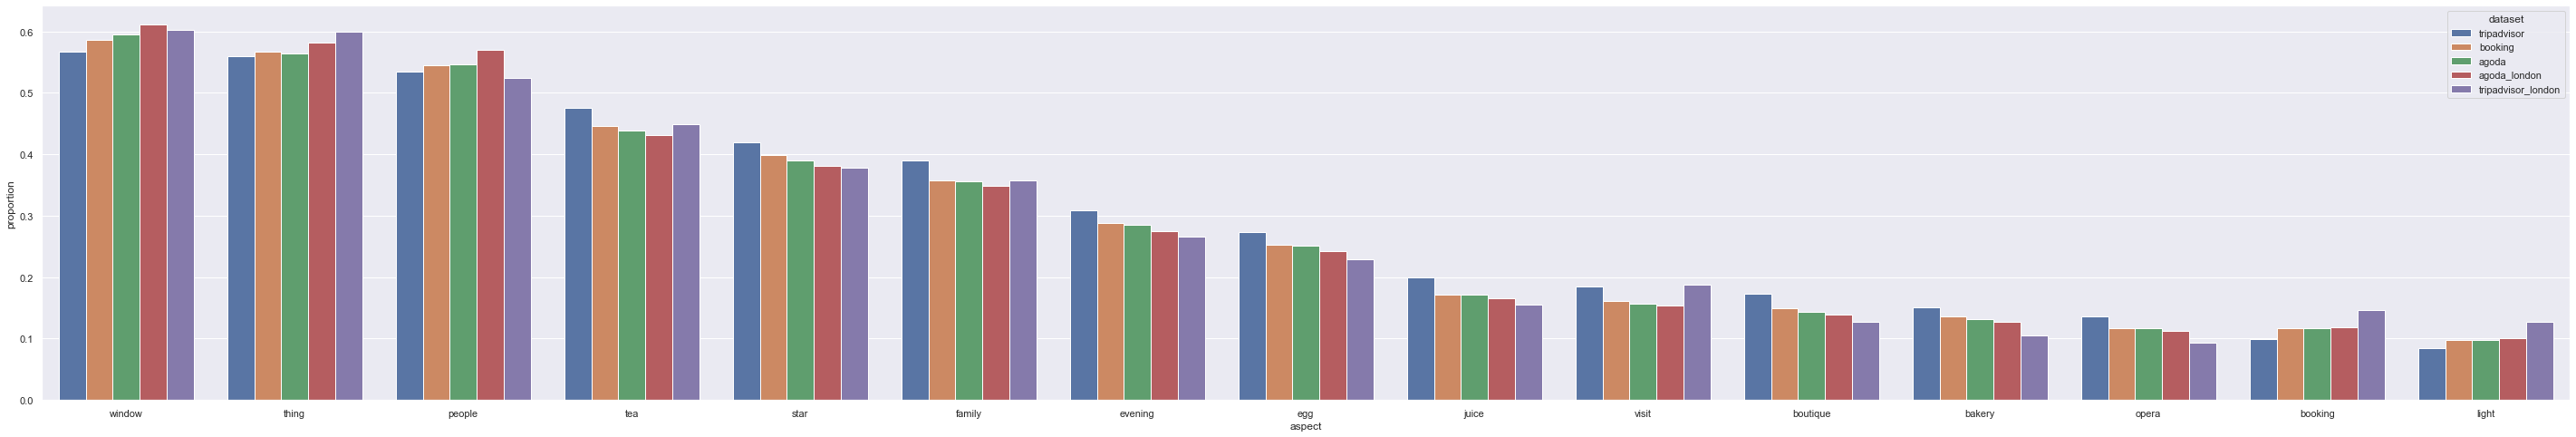

In [26]:
sns.barplot(data = df.query(f"aspect in {list(vars_[100:115].index)}"),
            x= 'aspect', y= 'proportion', hue='dataset')

#### Proportion de derniers 30 aspects fréquents.

<AxesSubplot:xlabel='aspect', ylabel='proportion'>

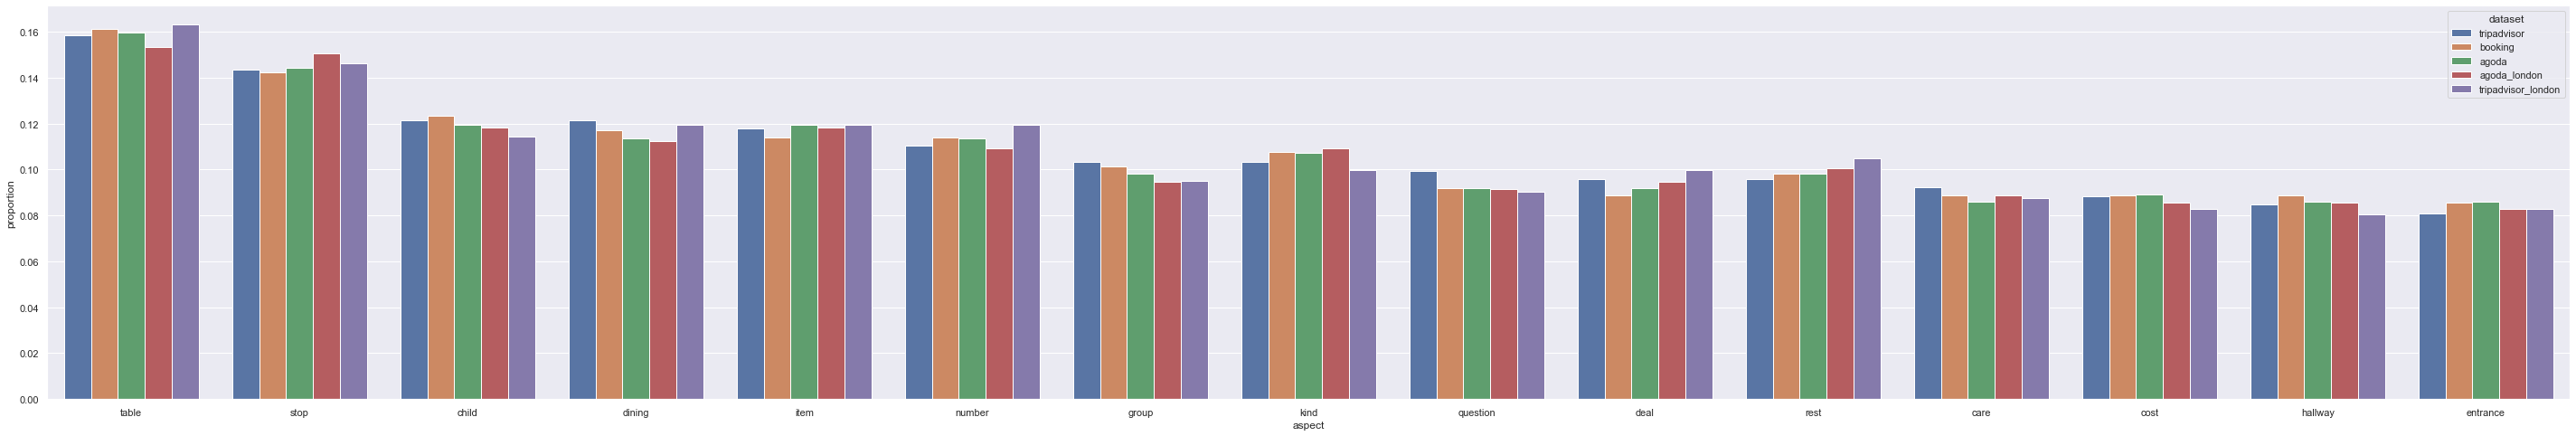

In [27]:
sns.barplot(data = df.query(f"aspect in {list(vars_[-15:].index)}"),
            x= 'aspect', y= 'proportion', hue='dataset')

### Critères de selection des aspects

In [28]:
means_ = rounded_proportion.mean()

In [29]:
sns.set(rc={'figure.figsize':(20,8)})

#### Histogramme des moyenne des proportions

##### Proportion inférieur à 2%

(0.08358959275936309, 2.0)

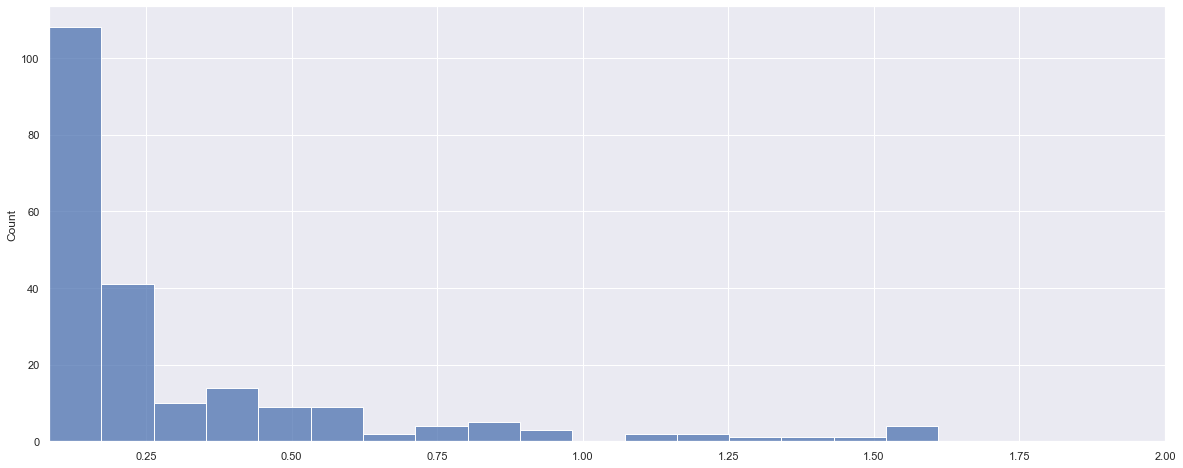

In [30]:
ax = sns.histplot(means_)
ax.set_xlim(means_.min(),2)

In [31]:
means_.median()

0.17769039017410618

In [32]:
len(means_[means_>=0.17769039017410618]), len(means_[means_>=0.1])

(111, 199)

- Avec une valeur de proportion supérieur ou égale à 0.17769039017410618, on inclue 111 mots la moitié des noms extraits.
- Avec une valeur de proportion supérieur ou égale à 0.1 on extrait 199 noms.

##### Histogramme des variances

(0.0, 0.0005)

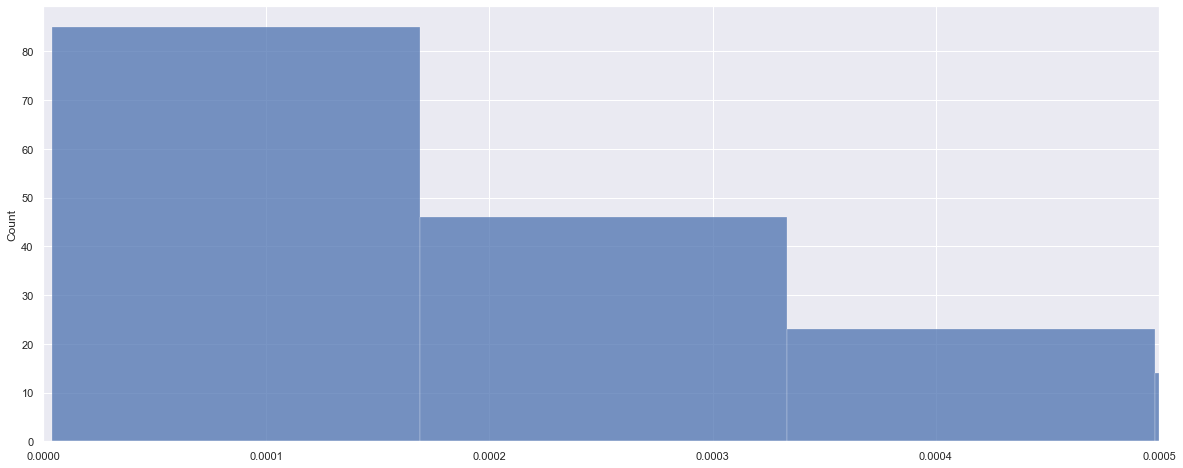

In [33]:
ax = sns.histplot(vars_)
ax.set_xlim(0, 0.0005)

In [34]:
vars_.median()

0.000257314692797973

In [35]:
len(vars_[vars_ >= 0.00005]), len(vars_[vars_ >= 0.0002])

(187, 128)

- Avec une variance inférieure à 0.00005, on inclue 187 noms (plus de la moitié 125 noms).
- Avec une variance supérieur à 0.0002 (présque la médiane), on inclue 128 noms (présque la moitié 125 noms).

#### Selection des aspects selon des condition sur la variance et la moyènne

##### 0.0002 <= variance <= 1  et mean > 0.1% et l'aspect partager entre les cinq datasets

In [36]:
aspects1 = set.intersection(set(vars_[(vars_ >= 0.002) & (vars_ <=1)].index), set(means_[means_>0.1].index))
print(aspects1)

{'station', 'snack', 'check', 'area', 'bar', 'bit', 'street', 'reception', 'tower', 'price', 'bed', 'day', 'drink', 'night', 'location', 'service', 'distance', 'hotel', 'eiffel', 'breakfast', 'airport', 'metro', 'bus', 'bathroom', 'shower', 'room', 'stay', 'food', 'afternoon', 'staff'}


In [37]:
len(aspects1)

30

**30 noms les plus fréquents sans application des critères de sélection**

In [38]:
print(set(dict(all_aspect_prob_freq[1][:30]).keys()))

{'station', 'water', 'snack', 'restaurant', 'bar', 'minute', 'place', 'lot', 'reception', 'tower', 'floor', 'bed', 'day', 'drink', 'night', 'location', 'service', 'staff', 'hotel', 'eiffel', 'breakfast', 'time', 'metro', 'bathroom', 'shower', 'room', 'stay', 'coffee', 'food', 'area'}


**Les apsects extraits par les condition qui ne sont pas dans la liste des 30 premiers aspects**

In [39]:
aspects1 - set(dict(all_aspect_prob_freq[1][:30]).keys())

{'afternoon', 'airport', 'bit', 'bus', 'check', 'distance', 'price', 'street'}

Nous arrivons à extraire des aspects moins fréquents et plus stables (comme price, distance, airport, bus) par rapport à si on extrait les aspects par un seuil sur l'ordre de l'aspect.

Nous testons avec une valeur de variance plus mois.

##### 0.00005 <= variance <= 1  et mean > 0.1% et l'aspect partager entre les cinq datasets

In [40]:
aspects2 = set.intersection(set(vars_[(vars_ >= 0.0005) & (vars_ <=1)].index), set(means_[means_>0.1].index))
print(aspects2)

{'station', 'luggage', 'louvre', 'tv', 'water', 'towel', 'touch', 'snack', 'check', 'restaurant', 'bar', 'bit', 'street', 'member', 'place', 'lot', 'shop', 'reception', 'tower', 'lobby', 'price', 'astute', 'mini', 'money', 'bed', 'day', 'drink', 'night', 'location', 'buffet', 'access', 'service', 'staff', 'hotel', 'distance', 'minibar', 'cafe', 'eiffel', 'desk', 'breakfast', 'time', 'airport', 'metro', 'bus', 'manager', 'facility', 'garden', 'experience', 'courtyard', 'walk', 'parking', 'trip', 'quality', 'bathroom', 'thank', 'dinner', 'customer', 'balcony', 'shower', 'attraction', 'room', 'view', 'stay', 'coffee', 'food', 'afternoon', 'area'}


In [41]:
len(aspects2)

67

**De nouveaux aspects ont été extraits:**

In [42]:
print(aspects2 - aspects1)

{'luggage', 'louvre', 'tv', 'water', 'towel', 'touch', 'restaurant', 'member', 'place', 'lot', 'shop', 'lobby', 'astute', 'mini', 'money', 'buffet', 'access', 'minibar', 'cafe', 'desk', 'time', 'manager', 'facility', 'garden', 'experience', 'courtyard', 'walk', 'parking', 'trip', 'quality', 'thank', 'dinner', 'customer', 'balcony', 'attraction', 'view', 'coffee'}


- il y a également des noms peuvent être des bruits **comme thank, astute, mini, min, day, lot, bit, eiffel, louver, touch, walk, afternoon, louvre, eiffel**
- les noms eiffel et louver ont été extrait car les dataset utilisé sont des hôtels de Paris et Londre. parfois les tourists de Londre peut mentioné leur experience à Paris.

**67 noms les plus fréquents sans application des critères de sélection**

In [43]:
print(set(dict(all_aspect_prob_freq[1][:67]).keys()))

{'station', 'size', 'water', 'snack', 'check', 'restaurant', 'bar', 'minute', 'min', 'bit', 'street', 'place', 'lot', 'door', 'family', 'shop', 'reception', 'morning', 'tower', 'price', 'lobby', 'floor', 'tea', 'bed', 'day', 'guest', 'city', 'window', 'star', 'drink', 'night', 'location', 'value', 'buffet', 'service', 'staff', 'hotel', 'distance', 'choice', 'noise', 'cafe', 'eiffel', 'people', 'breakfast', 'time', 'desk', 'metro', 'airport', 'bus', 'experience', 'walk', 'garden', 'trip', 'quality', 'bathroom', 'customer', 'shower', 'way', 'room', 'view', 'stay', 'coffee', 'food', 'afternoon', 'thing', 'air', 'area'}


**Les apsects extraits par les condition qui ne sont pas dans la liste des 67 premiers aspects sans application des conditions**

In [44]:
print(aspects2 - set(dict(all_aspect_prob_freq[1][:67]).keys()))

{'luggage', 'louvre', 'tv', 'towel', 'touch', 'member', 'astute', 'mini', 'money', 'access', 'minibar', 'facility', 'manager', 'courtyard', 'parking', 'thank', 'dinner', 'balcony', 'attraction'}


- Avec la diminution de la valeur de variance nous obtenons plus d'aspects qui peuvent etre utils comme **place, quality, tv, buffet, cafe, balcony, garden, view, parking, manager, shop, coffee, restaurant, courtyard, lobby, minibar, money, customer, facility, dinner**
- Avec une valeur de variance petite et dans l'intervalle\[0.00005, 1\]. nous peuvent obtenir des aspects moins fréquents (moins fréquents par rapport à l'extraction des aspects par leur ordre) et stable

**On choisit d'utilisé les conditions suivants pour l'extraction des aspects explicits:**

- 0.0005 <= variance(aspect) <=1
- la proportion moyenne de l'aspect supérieur ou égale à 0.1
- l'aspect doit être partagé entre les cinq datasets

#### Relations mathèmatiques

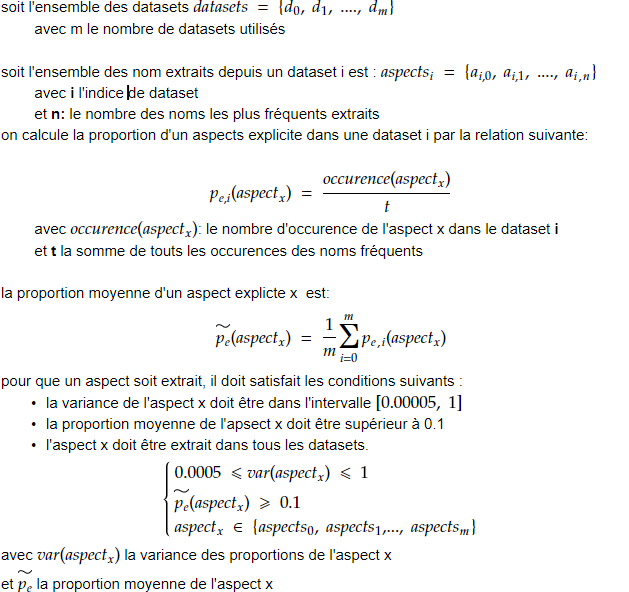

#### Enregistrement des aspects avec leur proportion

vers la fin, on élimine les noms indiqué comme bruits. Nous enregistrerons les aspects filtrés.

In [55]:
filtred_aspects = aspects2 - {'thank', 'astute', 'mini', 'min', 'day', 'lot', 'bit', 'eiffel', 'louvre', 'touch', 'walk', 'afternoon'}
print(filtred_aspects)

{'luggage', 'water', 'towel', 'snack', 'street', 'member', 'tower', 'money', 'drink', 'location', 'buffet', 'access', 'service', 'hotel', 'minibar', 'desk', 'breakfast', 'time', 'airport', 'bus', 'courtyard', 'garden', 'experience', 'trip', 'quality', 'bathroom', 'customer', 'balcony', 'attraction', 'room', 'stay', 'price', 'staff', 'station', 'tv', 'check', 'restaurant', 'bar', 'place', 'shop', 'reception', 'lobby', 'bed', 'night', 'distance', 'cafe', 'metro', 'manager', 'facility', 'parking', 'dinner', 'shower', 'view', 'food', 'coffee', 'area'}


In [60]:
file = open("explicit_aspects.txt", "w")
file.write(str(means_[list(filtred_aspects)].sort_values(ascending=False).to_dict()))
file.close()